In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

In [3]:
IMAGES_PATH = Path() /"images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [5]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## load data

In [34]:
tick = 'msft'
strat = 'grb_clf'

data = pd.read_hdf('data.h5', 'models/test_result/{}'.format(tick))
data.index.name = 'datetime'
data.head()

open        high         low       close    volume       SMA_5      SMA_21      SMA_63  return_1d  return_5d  ...       ATR  target_1d   log_clf   svm_clf   rnd_clf   mlp_clf   vot_clf   ada_clf   grb_clf  dummy_clf
datetime                                                                                                                        ...                                                                                                      
2020-04-02  151.860001  155.479996  150.360001  150.975189  49630700  150.724295  146.124742  159.414619   0.020497  -0.005460  ...  2.381442  -0.009253  0.009253 -0.009253 -0.009253  0.009253  0.009253  0.009253 -0.000000  -0.009253
2020-04-03  155.100006  157.380005  152.190002  149.584641  41243300  151.527502  145.548710  159.347355  -0.009253   0.027215  ...  2.127951   0.071733 -0.071733  0.071733  0.071733 -0.071733 -0.071733 -0.071733  0.071733   0.071733
2020-04-06  160.320007  166.500000  157.580002  160.708939  67111700  152.507687  145.720038  159.450356   0.071733   0.030970  ...  2.489044  -0.010829  0.010829 -0.010829  0.010829 -0.010829  0.010829  0.010829  0.010829  -0.010829
2020-04-07  169.589996  170.000000  163.259995  158.978073  62769000  153.631787  146.315983  159.548202  -0.010829   0.035994  ...  2.391663   0.009981 -0.009981  0.009981 -0.009981  0.009981 -0.009981 -0.009981 -0.009981   0.009981
2020-04-08  165.669998  166.669998  163.500000  160.572754  48318200  156.163919  146.510925  159.632725   0.009981   0.082129  ...  2.210486   0.000061 -0.000061  0.000061 -0.000061  0.000061 -0.000061 -0.000061 -0.000061   0.000061

[5 rows x 38 columns]

In [35]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_21', 'SMA_63',
       'return_1d', 'return_5d', 'return_10d', 'return_21d', 'return_42d',
       'return_63d', 'HT_TRENDLINE', 'bb_high', 'bb_low', 'BB_HIGH', 'BB_LOW',
       'RSI', 'MACD', 'PLUS_DM', 'MINUS_DM', 'ADX', 'PPO', 'STOCH', 'MFI',
       'AD', 'ATR', 'target_1d', 'log_clf', 'svm_clf', 'rnd_clf', 'mlp_clf',
       'vot_clf', 'ada_clf', 'grb_clf', 'dummy_clf'],
      dtype='object')

## Backtrader setup

## commission scheme

In [36]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

In [37]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [38]:
class SignalData(PandasData):

    cols = OHLCV + ['grb_clf'] #modify this for different classifier

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [39]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and prediction value in the series
        self.data_prediction = self.datas[0].grb_clf #modify this
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_prediction > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_prediction < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

### Create and configure Cerebro instance

In [40]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.broker.setcash(100000.0)
comminfo = FixedCommisionScheme()
cerebro.broker.addcommissioninfo(comminfo)

### Add input data

In [41]:
bt_data = SignalData(dataname=data)
cerebro.adddata(bt_data)

### Run strategy backtest

In [42]:
cerebro.addstrategy(MLStrategy)

0

In [43]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [44]:

results = cerebro.run()
ending_value = cerebro.broker.getvalue()
print(f'Final Portfolio Value: {ending_value:,.2f}')


2020-04-03, BUY CREATED --- Size: 644, Cash: 100000.00, Open: 155.10000610351562, Close: 149.5846405029297
2020-04-03, BUY EXECUTED --- Price: 155.10, Cost: 99884.40,Commission: 12.88
2020-04-07, SELL CREATED --- Size: 644
2020-04-07, SELL EXECUTED --- Price: 169.59, Cost: 99884.40,Commission: 12.88
2020-04-07, OPERATION RESULT --- Gross: 9331.55, Net: 9305.79
2020-04-14, BUY CREATED --- Size: 646, Cash: 109305.79, Open: 169.0, Close: 168.90626525878906
2020-04-14, BUY EXECUTED --- Price: 169.00, Cost: 109174.00,Commission: 12.92
2020-04-15, SELL CREATED --- Size: 646
2020-04-15, SELL EXECUTED --- Price: 171.20, Cost: 109174.00,Commission: 12.92
2020-04-15, OPERATION RESULT --- Gross: 1421.20, Net: 1395.36
2020-04-17, BUY CREATED --- Size: 616, Cash: 110701.15, Open: 179.5, Close: 173.67103576660156
2020-04-17, BUY EXECUTED --- Price: 179.50, Cost: 110572.00,Commission: 12.32
2020-04-21, SELL CREATED --- Size: 616
2020-04-21, SELL EXECUTED --- Price: 173.50, Cost: 110572.00,Commission:

In [45]:
# Extract inputs for pyfolio
pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = strat
returns.head(2)

index
2020-04-02 00:00:00+00:00    0.000000
2020-04-03 00:00:00+00:00   -0.035648
Name: grb_clf, dtype: float64

In [46]:
# get benchmark returns
passive_rets= data['target_1d']
passive_rets.index = passive_rets.index.tz_localize('UTC') 
passive_rets = passive_rets.filter(returns.index)
passive_rets.name = 'Buy-n-Hold'
passive_rets.head(2)

datetime
2020-04-02 00:00:00+00:00   -0.009253
2020-04-03 00:00:00+00:00    0.071733
Name: Buy-n-Hold, dtype: float64

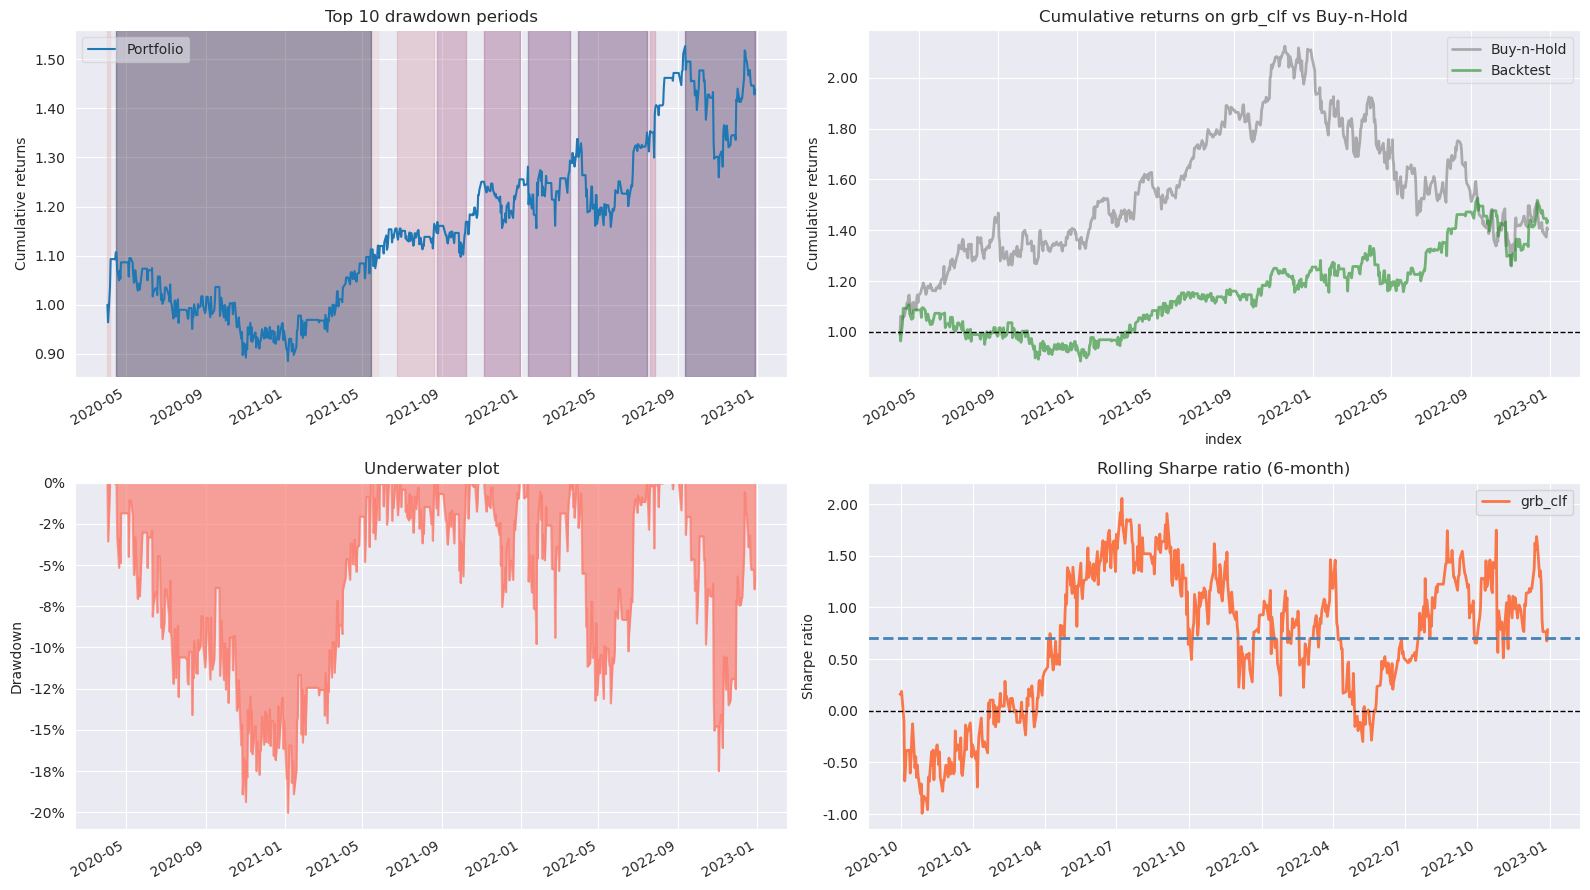

In [48]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_drawdown_periods(returns=returns, ax=axes[0])
pf.plot_rolling_returns(returns=returns,
                        factor_returns=passive_rets,
                        ax=axes[1], 
                        title='Cumulative returns on {} vs {}'
                        .format(strat, passive_rets.name))
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])


plt.legend()
plt.tight_layout()
save_fig("backtest_{}_{}_passive".format(tick,strat))

In [49]:
pf.show_perf_stats(returns=returns, positions=positions, transactions=transactions)

## Save results

In [50]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

#export
returns.to_hdf('backtrader.h5', 'pyfolio/{}/{}/returns'.format(tick,strat))
positions.to_hdf('backtrader.h5', 'pyfolio/{}/{}/positions'.format(tick,strat))
transactions.to_hdf('backtrader.h5', 'pyfolio/{}/{}/transactions/'.format(tick,strat))
gross_lev.to_hdf('backtrader.h5', 'pyfolio/{}/{}/gross_lev'.format(tick,strat))

##  pyfolio analysis

In [51]:
benchmark = pd.read_hdf('./assets.h5', 'yfinance/index/vtsax')

In [52]:
benchmark.index.name = 'datetime'
benchmark_rets = benchmark['Adj Close'].pct_change()
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'VTSAX'
benchmark_rets.head(2)

datetime
2020-04-02 00:00:00+00:00    0.020558
2020-04-03 00:00:00+00:00   -0.016541
Name: VTSAX, dtype: float64

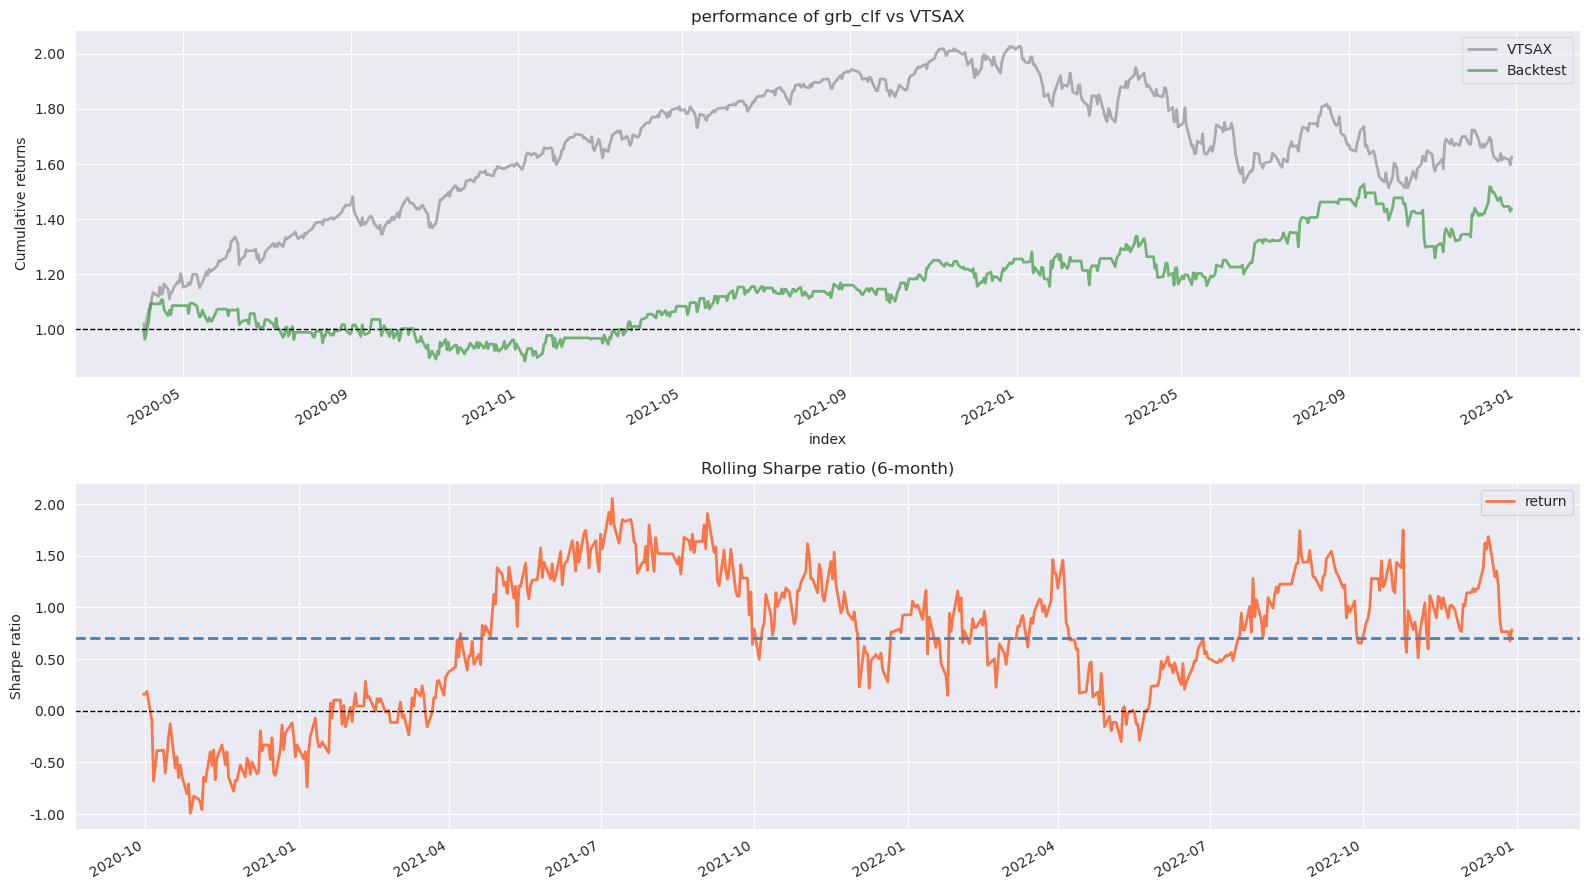

In [54]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], 
                        title='performance of {} vs {}'
                       .format(strat,benchmark_rets.name))
axes[1].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

plt.grid(True)
plt.legend()
plt.tight_layout()
save_fig("backtest_{}_{}_{}".format(tick,strat,benchmark_rets.name))

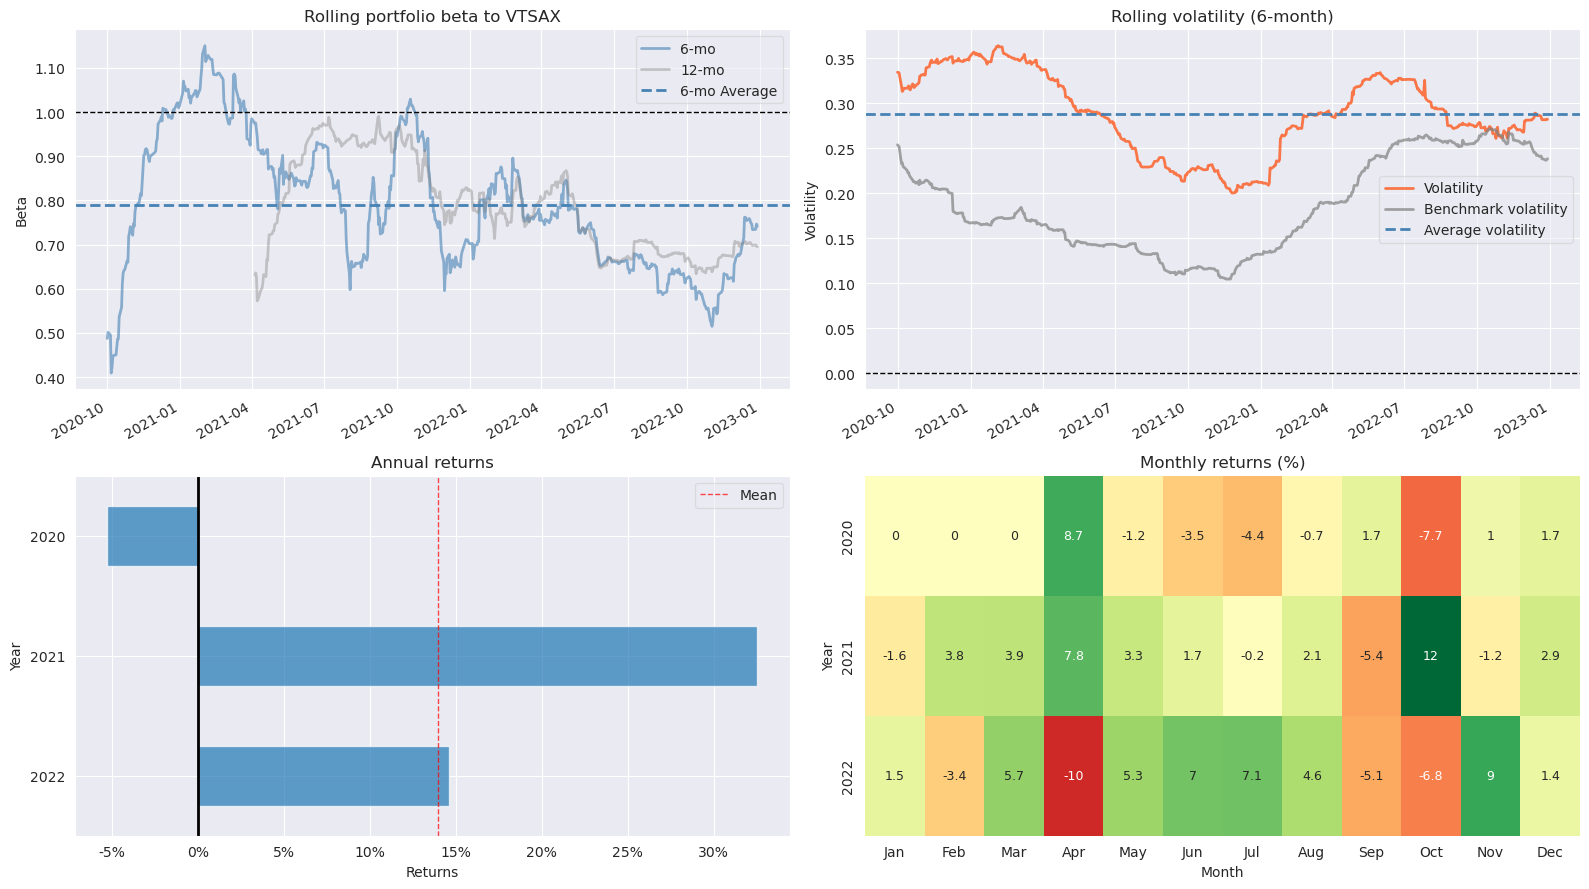

In [55]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
pf.plot_annual_returns(returns=returns, ax=axes[2])
pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

plt.tight_layout()
save_fig("pyfolio_results _{}_{}".format(tick,strat,benchmark_rets.name))

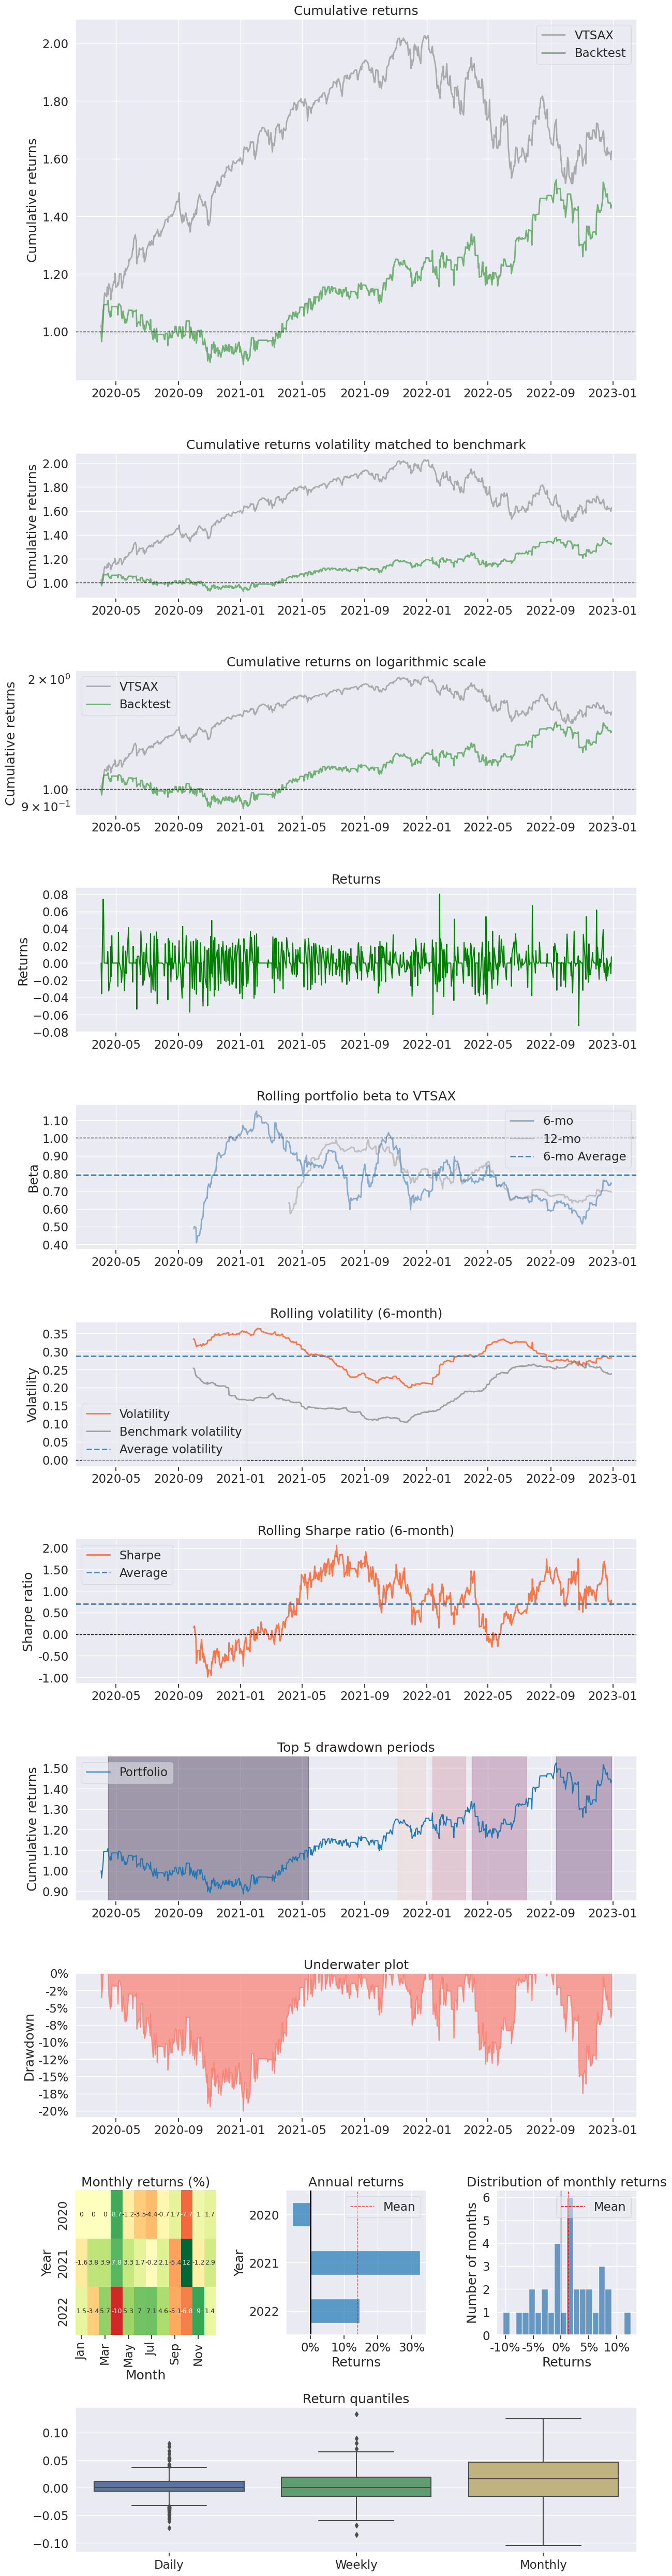

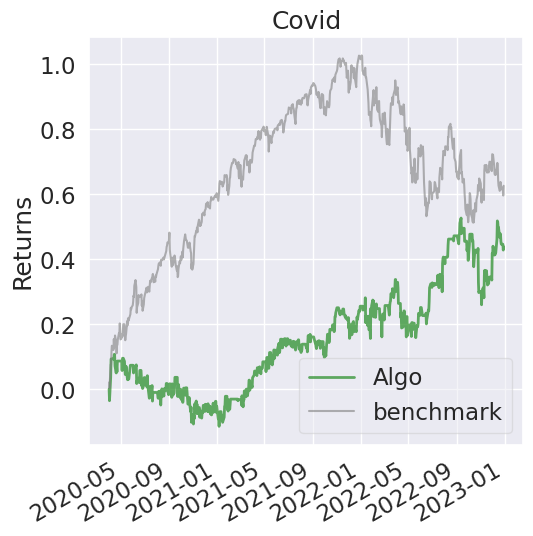

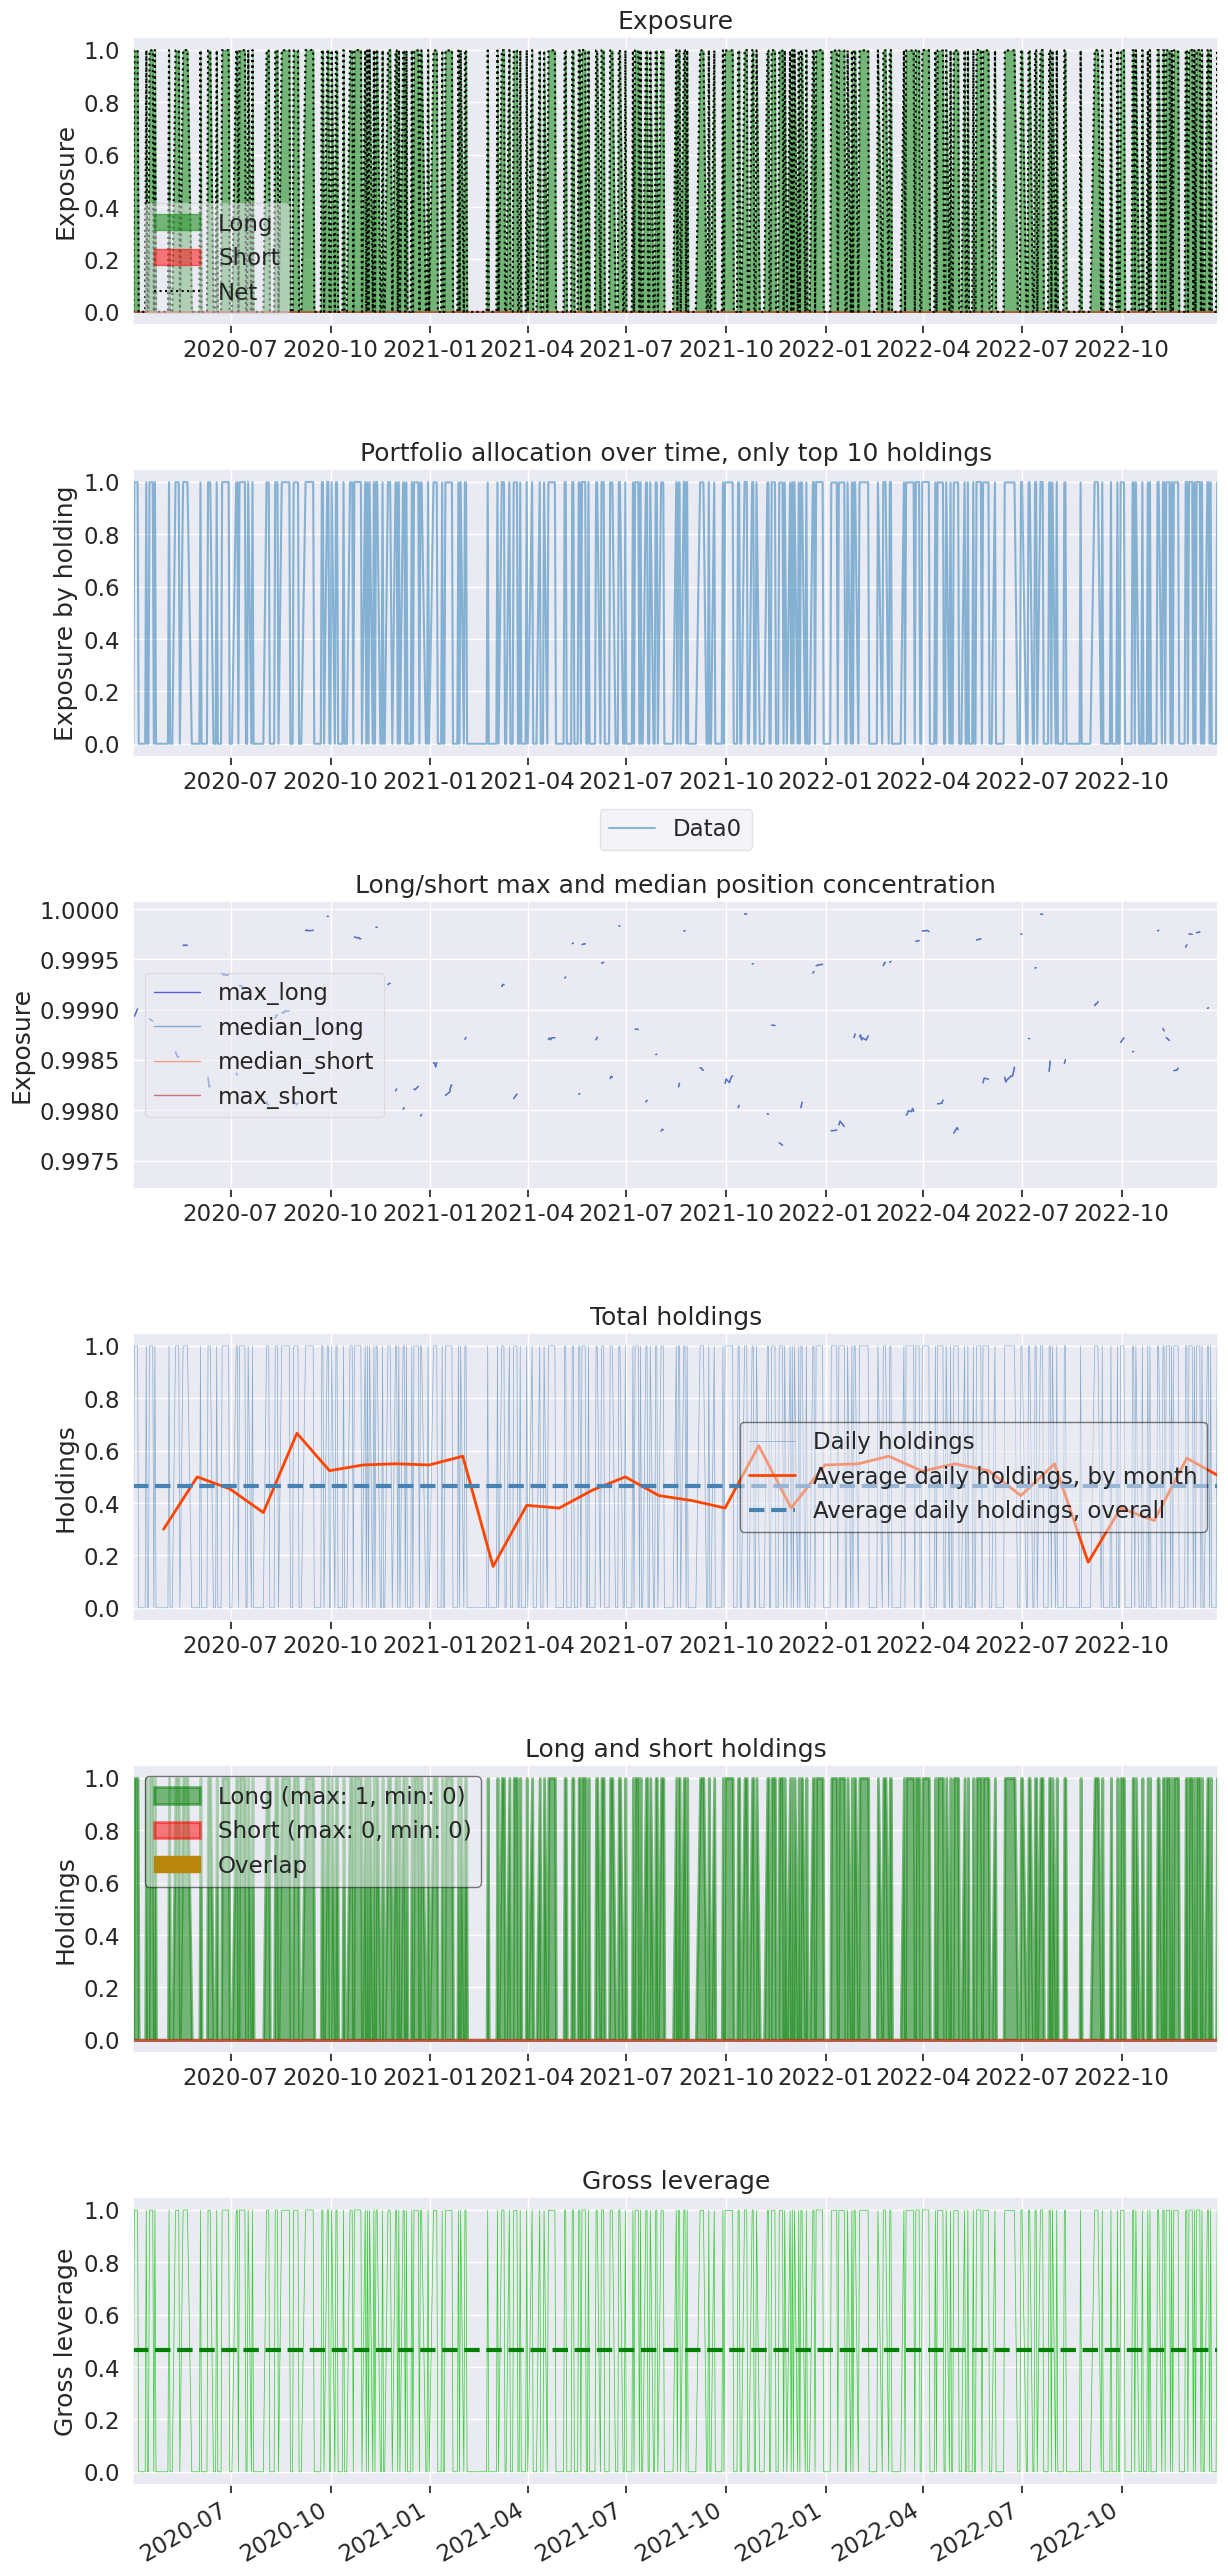

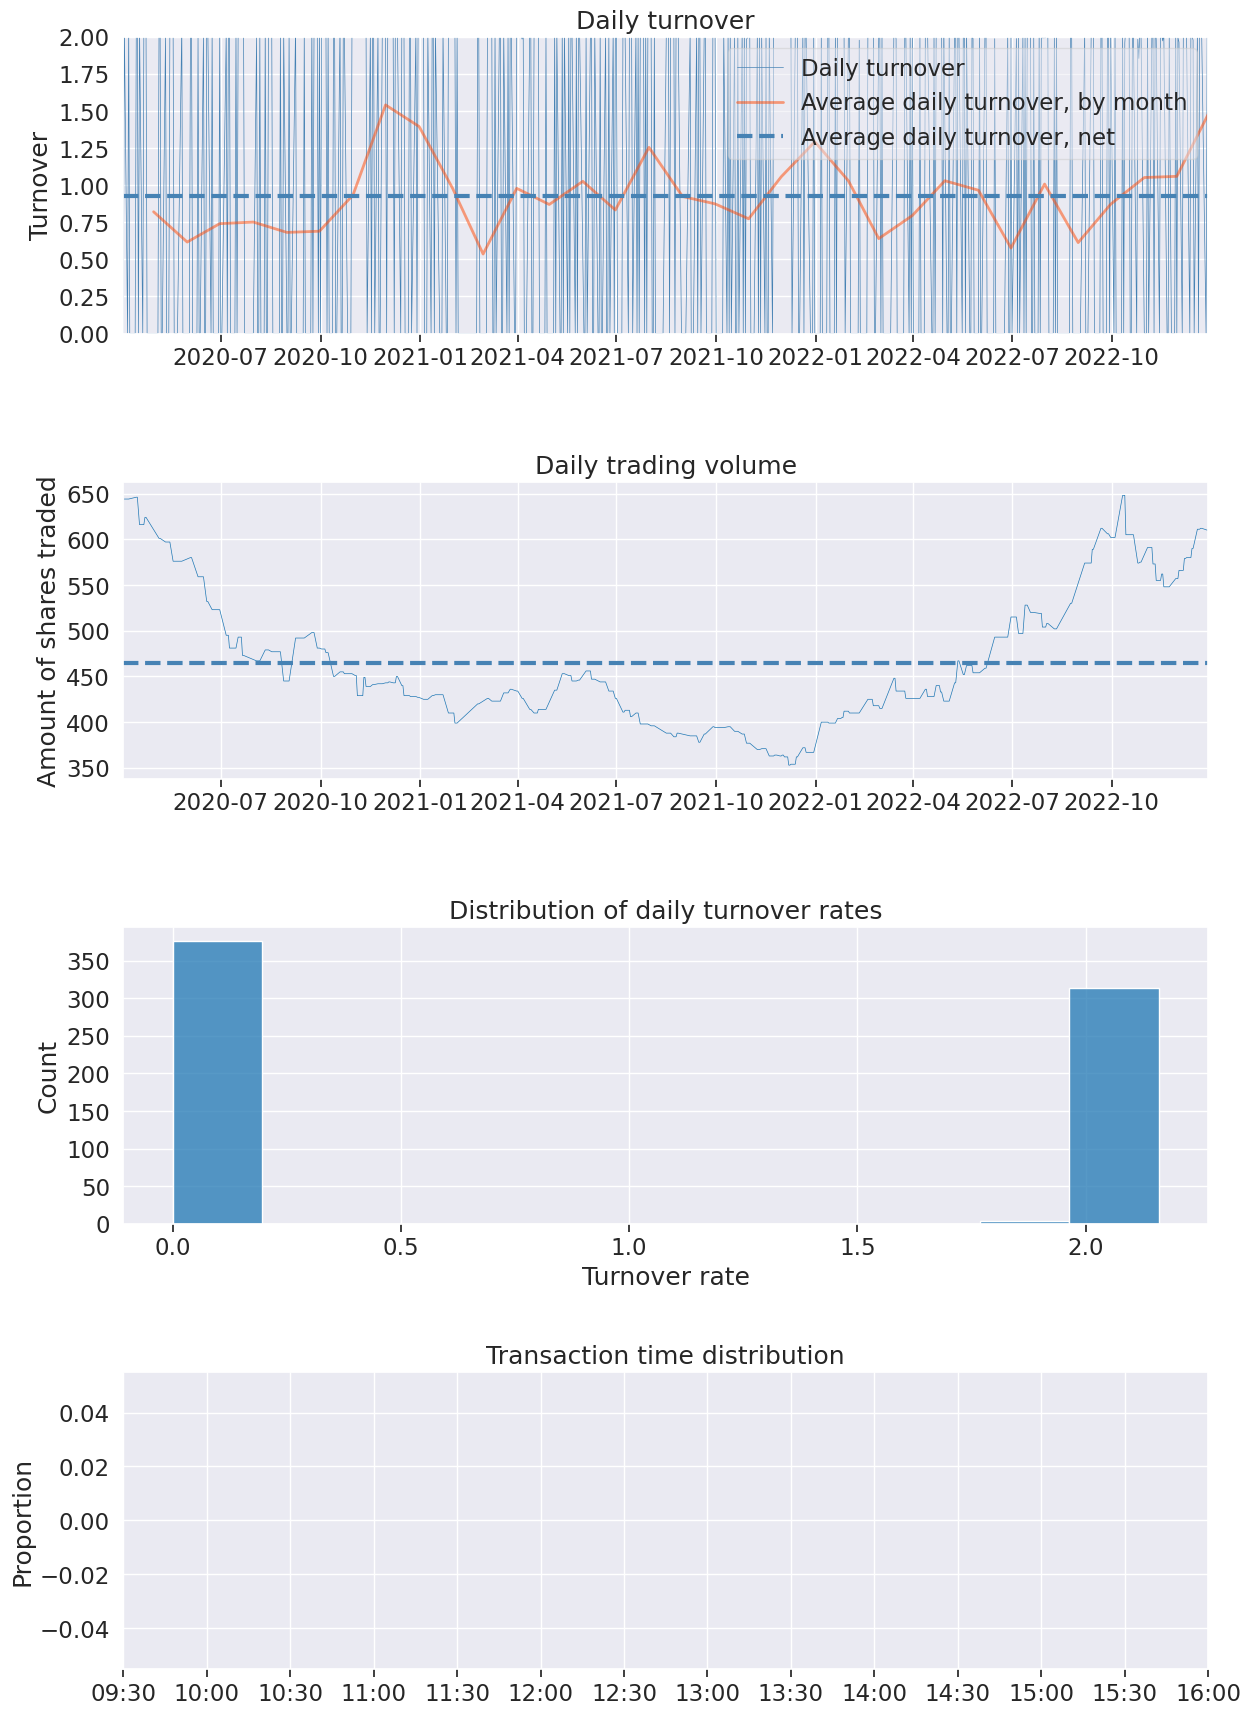

In [56]:
pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark_rets.dropna())